In [6]:
import pandas as pd 

from zaml.common.utils import load_state

import model_engine, zaml
model_engine.__version__, zaml.__version__

('v1.13.0', '34.5.2')

In [151]:
pipeline = load_state('/d/shared/silver_projects_v2/redstonefcu/creditcardv2/modeling/model_artifacts/creditcard/model3/pipeline.obj')

ZAML version mismatch: current enviroment is on ZAML 34.5.2
                      but the loaded object is built on ZAML 34.4.1. Loading serialized
                      object from different versions are not recommended and may yield unexpected
                      errors or results.
Dependency version mismatch: These dependencies have different versions when the object was built
                      (name, curr_ver, org_ver): [('docmill', '0.1.2', '0.1.0'), ('h5py', '3.13.0', '3.11.0'), ('ipython', '8.36.0', '8.26.0'), ('ipywidgets', '8.1.7', '7.8.1'), ('joblib', '1.5.0', '1.4.2'), ('jupyter-book', '1.0.4.post1', '0.15.1'), ('matplotlib', '3.10.3', '3.9.0'), ('numba', '0.57.0', '0.56.4'), ('plotly', '5.24.1', '5.22.0'), ('pyarrow-hotfix', '0.7', '0.6'), ('PyYAML', '6.0.2', '6.0.1'), ('simplejson', '3.20.1', '3.19.2'), ('Sphinx', '7.4.7', '4.5.0'), ('sphinx-rtd-theme', '3.0.2', '1.3.0'), ('sphinxcontrib-applehelp', '1.0.7', '1.0.4'), ('sphinxcontrib-bibtex', '2.6.1', '2.5.0'), ('sph

In [154]:
pipeline.model.weights

[0.6, 0.4]

In [ ]:
new_model = LinearEnsembleModel([model.models[0], model.models[1]], weights = weights)

In [2]:
# client_model_name = 'clientmodel2b'
# national_model_name = 'nationalmodel2b'
# ensemble_weights = [0.5, 0.5]

# client_model_path = f'/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/{client_model_name}'
# national_model_path = f'/d/shared/users/lyt/penfed_poc1_national_models/{national_model_name}'

# client_submodel = load_state(os.path.join(client_model_path, 'model.obj'))
# national_submodel = load_state(os.path.join(national_model_path, 'model.obj'))

In [103]:
final_model_path = '/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/model1Ensemble'
pipe = load_state(os.path.join(final_model_path, 'pipeline.obj'))

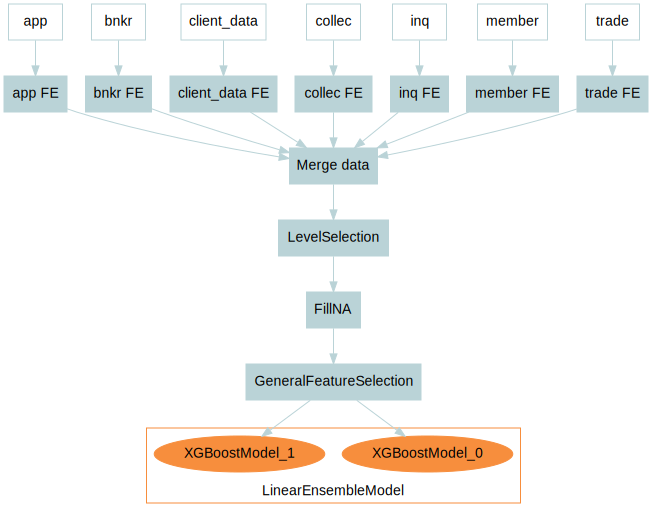

In [105]:
pipe.display()

In [106]:
with open(os.path.join(final_model_path, 'keep_features.json'), 'r') as file: 
    keep_keys = json.load(file)

In [107]:
data_dict = {}

In [108]:
for table, col in keep_keys.items(): 
    if table != 'client_data': 
        table_df = pd.read_parquet(f'/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/penfed_autoindirect/{table}.parquet')
        data_dict[table] = table_df
#         table_df = table_df[col]
#         fe = fe.merge(table_df, left_index = True, 
#                       right_index = True, how = 'left')
    

In [109]:
penfed_app = pd.read_parquet('/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/penfed_autoindirect/app.parquet')
penfed_client = pd.read_parquet('/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/penfed_autoindirect/client_data.parquet')
penfed_client['client_data_LTV_NORM'] = pd.to_numeric(penfed_client['Front_End_LTV'], errors='coerce')
penfed_client['client_data_LTV_NORM'].describe()

count    6.368290e+05
mean     2.192399e+02
std      2.574810e+04
min     -1.344000e+01
25%      7.490140e+01
50%      9.002000e+01
75%      1.052800e+02
max      8.615800e+06
Name: client_data_LTV_NORM, dtype: float64

In [111]:
data_dict['app'] = penfed_app
data_dict['client_data'] = penfed_client

In [112]:
fe = pipe.transform(data_dict)

-------------------------
Name: app
Transformer type: None
Number of features: 18
Time spent: 0.000s
-------------------------
Name: bnkr
Transformer type: None
Number of features: 8
Time spent: 0.000s
-------------------------
Name: client_data
Transformer type: None
Number of features: 431
Time spent: 0.000s
-------------------------
Name: collec
Transformer type: None
Number of features: 5
Time spent: 0.000s
-------------------------
Name: inq
Transformer type: None
Number of features: 13
Time spent: 0.000s
-------------------------
Name: member
Transformer type: None
Number of features: 28
Time spent: 0.000s
-------------------------
Name: trade
Transformer type: None
Number of features: 216
Time spent: 0.000s
-------------------------
Name: app FE
Transformer type: OneToOneEngine
Number of features: 0
Time spent: 0.021s
-------------------------
Name: bnkr FE
Transformer type: ManyToOneEngine
Number of features: 8
Time spent: 0.002s
-------------------------
Name: client_data FE
T

`dropped_features_` is empty. Input dataframe is returned.


In [122]:
penfed_scores = pipe.model.predict(fe)

In [123]:
penfed_scores = penfed_scores.to_frame().rename(columns={0: 'final_model_predictions'}).reset_index().set_index('ZEST_KEY')

In [126]:
penfed_scores

,final_model_predictions
ZEST_KEY,
70354826_1_229_22,0.222768
70115200_1_229_22,0.280018
70799310_1_229_22,0.193973
69747275_1_229_22,0.129335
70287537_1_229_22,0.074517
...,...
108277439_2_229_22,0.378831
108535882_2_229_22,0.043910
109730887_2_229_22,0.018412


In [135]:
client_model_scores = pipe.model.models[0][1].predict(fe)
national_model_scores = pipe.model.models[1][1].predict(fe)

In [142]:
client_model_scores = client_model_scores.to_frame().rename(columns={0: 'client_submodel_pred'}).reset_index().set_index('ZEST_KEY')
national_model_scores = national_model_scores.to_frame().rename(columns={0: 'national_submodel_pred'}).reset_index().set_index('ZEST_KEY')

In [144]:
penfed_scores_df = penfed_scores.merge(client_model_scores, left_index = True, right_index = True).merge(national_model_scores, left_index = True, right_index = True)

In [150]:
penfed_scores_df.to_parquet(os.path.join(final_model_path, 'penfed_autoindirectv1_scores.parquet'))

In [ ]:
# # Validate Scores using Origence POC test data

# test_fe = pd.read_parquet(os.path.join(client_model_path, 'test_fe_data.parquet')).set_index('ZEST_KEY')
# test_scores  = pd.read_parquet(os.path.join(client_model_path, 'test_scores.parquet')).set_index('ZEST_KEY')
# print(test_scores.shape)

# sum(test_scores['final_model_predictions'] == client_submodel.predict(test_fe))

In [39]:
# fe = penfed_app[['is_client']]
# penfed_app[['is_client']].shape

# for table, col in keep_keys.items(): 
#     if table != 'client_data': 
#         table_df = pd.read_parquet(f'/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/penfed_autoindirect/{table}.parquet')
#         table_df = table_df[col]
#         fe = fe.merge(table_df, left_index = True, 
#                       right_index = True, how = 'left')

# fe = fe.merge(penfed_client[['client_data_LTV_NORM']], 
#               left_index = True, 
#               right_index = True, how = 'left')
# fe.shape

# penfed_fe = fe.drop('is_client', axis=1)

# penfed_fe = penfed_fe.fillna(-1)
# penfed_fe.head(5)

# penfed_fe.shape

In [80]:
# client_pred = client_submodel.predict(penfed_fe)
# national_pred = national_submodel.predict(penfed_fe)

# client_pred = client_pred.to_frame().rename(columns = {0:'client_model_predictions'})
# national_pred = national_pred.to_frame().rename(columns = {0:'national_model_predictions'})
# pred_df = client_pred.merge(national_pred, left_index = True, right_index = True)

In [100]:
# pred_df['ensemble_pred'] = pred_df['client_model_predictions']*0.5 + pred_df['national_model_predictions']*0.5

In [102]:
penfed_target = pd.read_parquet('/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/penfed_autoindirect/target.parquet')
penfed_target

,appId,appDate,flgFunded,flgApproved,final_DQ30_m3,final_DQ30_m3_source,final_DQ30_m3_status,final_DQ30_m3_sample_weight,final_DateDQ30_m3,final_DQ30_m6,...,final_CO_m36,final_CO_m36_source,final_CO_m36_status,final_CO_m36_sample_weight,final_DateCO_m36,proxy_MSO_target_CO,proxy_CO,final_MSO_target_CO,final_CO,ARCHIVE_DATE
ZEST_KEY,,,,,,,,,,,,,,,,,,,,,
70354826_1_229_22,70354826,2021-02-12,0,1,NaN,missing,nohit,1,NaT,NaN,...,NaN,missing,nohit,1,NaT,NaN,NaN,NaN,NaN,2020-12-31
70115200_1_229_22,70115200,2021-02-01,0,0,NaN,missing,nohit,1,NaT,NaN,...,NaN,missing,nohit,1,NaT,NaN,NaN,NaN,NaN,2020-12-31
70799310_1_229_22,70799310,2021-03-04,0,0,NaN,missing,nohit,1,NaT,NaN,...,NaN,missing,nohit,1,NaT,NaN,NaN,NaN,NaN,2020-12-31
69747275_1_229_22,69747275,2021-01-13,0,0,0.0,proxy,season,1,NaT,0.0,...,0.0,proxy,season,1,NaT,NaN,0.0,NaN,0.0,2020-12-31
70287537_1_229_22,70287537,2021-02-09,1,1,0.0,proxy,season,1,2023-03-01,0.0,...,1.0,proxy,season,1,2023-07-30,29.0,1.0,29.0,1.0,2020-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108277439_2_229_22,108277439,2025-01-10,0,0,NaN,missing,nohit,1,NaT,NaN,...,NaN,missing,nohit,1,NaT,NaN,NaN,NaN,NaN,2024-12-31
108535882_2_229_22,108535882,2025-01-21,0,0,NaN,missing,nohit,1,NaT,NaN,...,NaN,missing,nohit,1,NaT,NaN,NaN,NaN,NaN,2024-12-31
109730887_2_229_22,109730887,2025-03-04,0,0,NaN,missing,nohit,1,NaT,NaN,...,NaN,missing,nohit,1,NaT,NaN,NaN,NaN,NaN,2024-12-31


In [101]:
pred_df

,client_model_predictions,national_model_predictions,ensemble_pred
ZEST_KEY,,,
70354826_1_229_22,0.117889,0.327648,0.222768
70115200_1_229_22,0.250385,0.309652,0.280018
70799310_1_229_22,0.205098,0.182848,0.193973
69747275_1_229_22,0.123082,0.135587,0.129335
70287537_1_229_22,0.083500,0.065533,0.074517
...,...,...,...
108277439_2_229_22,0.417353,0.340309,0.378831
108535882_2_229_22,0.053731,0.034089,0.043910
109730887_2_229_22,0.023937,0.012887,0.018412


In [86]:
penfed_client['benchmark_scores_from_client']

ZEST_KEY
70354826_1_229_22     681.0
70115200_1_229_22     611.0
70799310_1_229_22     622.0
69747275_1_229_22     684.0
70287537_1_229_22     746.0
                      ...  
108277439_2_229_22      nan
108535882_2_229_22    819.0
109730887_2_229_22    842.0
108270019_2_229_22    839.0
110455147_2_229_22    602.0
Name: benchmark_scores_from_client, Length: 651809, dtype: object

In [92]:
for i in penfed_client.columns.tolist(): 
    if 'score' in i.lower():
        print(i)

benchmark_scores
Max_Credit_Risk_Score
benchmark_scores_from_client


In [94]:
penfed_client['benchmark_scores'].describe()

count    635120.000000
mean        724.773254
std          70.047234
min         339.000000
25%         674.000000
50%         729.000000
75%         781.000000
max         850.000000
Name: benchmark_scores, dtype: float64

In [96]:
penfed_client['benchmark_scores_from_client'] = pd.to_numeric(penfed_client['benchmark_scores_from_client'], 
                                                              errors='coerce') 

penfed_client['Max_Credit_Risk_Score'] = pd.to_numeric(penfed_client['Max_Credit_Risk_Score'], 
                                                       errors='coerce')                                                        

In [98]:
penfed_client[['benchmark_scores_from_client', 'Max_Credit_Risk_Score']].describe()

,benchmark_scores_from_client,Max_Credit_Risk_Score
count,635120.000000,637646.000000
mean,724.773265,731.987385
std,70.047235,65.207109
min,339.000000,339.000000
25%,674.000000,682.000000
50%,729.000000,735.000000
75%,781.000000,785.000000
max,850.000000,850.000000


In [ ]:
pipeline = load_state()

In [ ]:
pipeline_factory['model']['params'].update({'weights': [0.4, 0.6]})